# Fellowship AI Application

Used the python script from STL10's website to download and get the labels for the problem. And imported the dataset into this Notebook. For the test dataset, imported an already existing STL-10 dataset. Approached this as a supervised learning problem.

In [1]:
import os
import pandas as pd
from fastai.vision.all import *

In [2]:
train_data = Path("../input/stl-training-data-with-labels/img")
train_data.ls()

(#10) [Path('../input/stl-training-data-with-labels/img/5'),Path('../input/stl-training-data-with-labels/img/6'),Path('../input/stl-training-data-with-labels/img/4'),Path('../input/stl-training-data-with-labels/img/7'),Path('../input/stl-training-data-with-labels/img/10'),Path('../input/stl-training-data-with-labels/img/1'),Path('../input/stl-training-data-with-labels/img/2'),Path('../input/stl-training-data-with-labels/img/3'),Path('../input/stl-training-data-with-labels/img/8'),Path('../input/stl-training-data-with-labels/img/9')]

In [3]:
fns = get_image_files(train_data)
fns

(#5000) [Path('../input/stl-training-data-with-labels/img/5/3880.png'),Path('../input/stl-training-data-with-labels/img/5/4302.png'),Path('../input/stl-training-data-with-labels/img/5/3054.png'),Path('../input/stl-training-data-with-labels/img/5/4694.png'),Path('../input/stl-training-data-with-labels/img/5/4425.png'),Path('../input/stl-training-data-with-labels/img/5/1965.png'),Path('../input/stl-training-data-with-labels/img/5/1557.png'),Path('../input/stl-training-data-with-labels/img/5/4307.png'),Path('../input/stl-training-data-with-labels/img/5/3689.png'),Path('../input/stl-training-data-with-labels/img/5/1606.png')...]

In [4]:
stl10 = DataBlock(blocks=(ImageBlock, CategoryBlock),
   get_items=get_image_files,
   get_y=parent_label,
   splitter=RandomSplitter(valid_pct=0.2, seed=42),
   item_tfms=RandomResizedCrop(224, min_scale=0.5),
   batch_tfms=aug_transforms(size=96))

In [5]:
# For our reference
idx2lbl = {1:"airplane",
          2:"bird",
          3:"car",
          4:"cat",
          5:"deer",
          6:"dog",
          7:"horse",
          8:"monkey",
          9:"ship",
          10:"truck",}

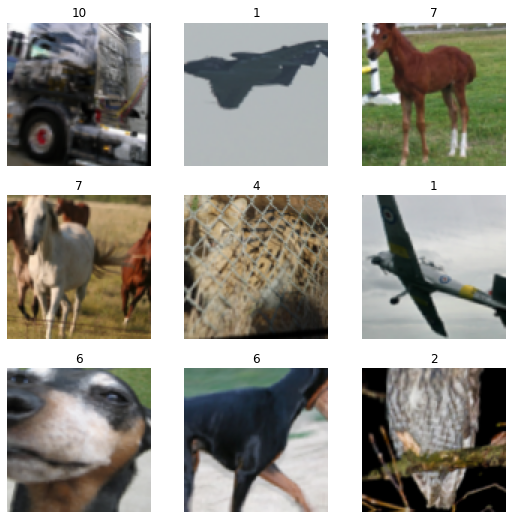

In [6]:
dls = stl10.dataloaders(train_data)
dls.train.show_batch()

In [7]:
learn = cnn_learner(dls, resnet18, metrics=accuracy) #Using ResNet18

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


### Finding learning rates

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.004365158267319202)

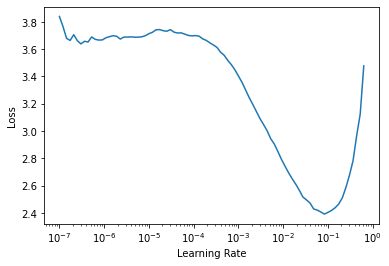

In [8]:
learn.to_native_fp16().lr_find()

This version will be without converting it to fp16

In [9]:
#Steep ==> 1e-2
#learn = learn.to_native_fp16() #native fp16 is apparently a faster way than fastai's own fp16

## Using discriminative learning rates

```
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-4,1e-2))
```

Let's use Fastai's fine_tune this time. This will also provide us with discriminative learning rates

In [10]:
learn.fine_tune(15, freeze_epochs=2) # with discriminative learning rates

epoch,train_loss,valid_loss,accuracy,time
0,1.965042,0.677182,0.772000,00:19
1,1.199386,0.556352,0.803000,00:16


epoch,train_loss,valid_loss,accuracy,time
0,0.743706,0.459854,0.853000,00:19
1,0.634388,0.403501,0.872000,00:17
2,0.542111,0.357734,0.876000,00:17
3,0.467862,0.388030,0.878000,00:19
4,0.444464,0.390229,0.897000,00:17
5,0.333508,0.394317,0.882000,00:18
6,0.277375,0.367082,0.892000,00:18
7,0.247333,0.397351,0.880000,00:19
8,0.221270,0.374655,0.899000,00:17
9,0.183905,0.353232,0.897000,00:18


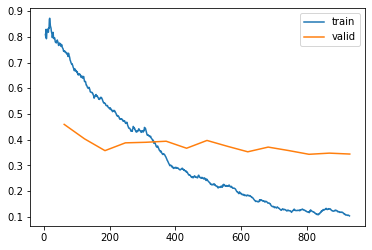

In [11]:
learn.recorder.plot_loss()


Let's see what our model gets confused most on

In [12]:
#interp = ClassificationInterpretation.from_learner(learn)
#interp.most_confused(min_val=3) #if there's at least 4 wrong predictions 

Exporting our model

In [13]:
learn.export()

### It's inference time!

In [14]:
learn_inf = load_learner("./export.pkl")

A test prediction

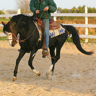

In [15]:
img =  Image.open("../input/stl10/test_images/test_image_png_1.png").convert('RGB')
img

In [16]:
learn_inf.predict("../input/stl10/test_images/test_image_png_1.png")[0]

'7'

In [17]:
test_set = Path("../input/stl10/test_images").ls()
test_set

(#8000) [Path('../input/stl10/test_images/test_image_png_2568.png'),Path('../input/stl10/test_images/test_image_png_5629.png'),Path('../input/stl10/test_images/test_image_png_2334.png'),Path('../input/stl10/test_images/test_image_png_3292.png'),Path('../input/stl10/test_images/test_image_png_3471.png'),Path('../input/stl10/test_images/test_image_png_7157.png'),Path('../input/stl10/test_images/test_image_png_1743.png'),Path('../input/stl10/test_images/test_image_png_6685.png'),Path('../input/stl10/test_images/test_image_png_4663.png'),Path('../input/stl10/test_images/test_image_png_1637.png')...]

In [18]:
#test_dl = DataLoader(test_set, batch_size=64, shuffle=False)

In [19]:
#hide
pred_list = []
og_list = []
for i in test_set:
    og_list.append(i)
    pred_list.append(learn_inf.predict(i)[0])

~~This time let's try test time augmentation~~

In [20]:
#preds, _ = learn.tta(dl=test_dl)# having issues with the test dataloader 

In [21]:
sub = pd.DataFrame(list(zip(og_list,pred_list)), columns=['Id','Category'])
sub

,Id,Category
0,../input/stl10/test_images/test_image_png_2568.png,8
1,../input/stl10/test_images/test_image_png_5629.png,10
2,../input/stl10/test_images/test_image_png_2334.png,10
3,../input/stl10/test_images/test_image_png_3292.png,4
4,../input/stl10/test_images/test_image_png_3471.png,1
...,...,...
7995,../input/stl10/test_images/test_image_png_7476.png,5
7996,../input/stl10/test_images/test_image_png_1173.png,7
7997,../input/stl10/test_images/test_image_png_6399.png,7
7998,../input/stl10/test_images/test_image_png_3643.png,9


Final predictions:

In [22]:
sub.to_csv('STL_10_predictions.csv',index=False)